In [2]:
import numpy as np
import pandas as pd
import sympy as sympy

import seaborn as sns
import matplotlib.pyplot as plt

from SCRBenchmark.Constants import StringKeys as sk
import SCRBenchmark.SRSDFeynman as srsdf
from SCRBenchmark import Benchmark

from SCRBenchmark import FEYNMAN_SRSD_HARD,HARD_NOISE_LEVELS,HARD_SAMPLE_SIZES
from SCRBenchmark import BenchmarkSuite


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=UserWarning)

# Generating Data
Our benchmark builds upon the Feynman benchmarks originally used to benchmark symbolic regression algorithms [Udrescu2020]. However, we use the version of [Matsubara2022] which adapts/corrects the equations and sampling ranges.


## Generate the full benchmark suite
To the whole range of benchmark data we can generate all instances defined in the `BenchmarkSuite`. This includes a curated list of _hard_ equations from which we sample data of fixed sizes and fixed noise levels. This is detailed in [using_the_benchmark.ipynb](using_the_benchmark.ipynb)

In [ ]:
#creates one folder per equation under the parent folder
# each equation folder contains the info file as json
# and the data files for each configuration as csv
BenchmarkSuite.create_hard_instances(target_folder = './data',
                                        Equations=FEYNMAN_SRSD_HARD,
                                        sample_sizes=HARD_SAMPLE_SIZES,
                                        noise_levels=HARD_NOISE_LEVELS,
                                        repetitions= 10 ) # use a fixed set of seeds

## Generate data for a single expression
Alternatively, instead of using the full `BenchmarkSuite` we can instantiate one `Benchmark` instance primed with a single equation, e.g., `FeynmanICh6Eq20`.

In [3]:
ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20)

From this benchmark instance we can generate data as a 2d numpy array using `Benchmark.create_dataset(...)` or generate a pandas dataframe with named, readable columns using `Benchmark.create_dataframe(...)`. Both variants are interchangeable, and the last column always contains the target value.

The following example fixes the random seed before dataset sampling to show that these two methods are indeed interchangeable.


In [4]:

(training, test) = ICh6Eq20.create_dataset(sample_size=1000, noise_level = 0, seed = 0, patience= 10)

(training_df, test_df) = ICh6Eq20.create_dataframe(sample_size=1000, noise_level = 0, seed = 0, patience= 10)

train_df_to_np = training_df.to_numpy()
test_df_to_np = test_df.to_numpy()

assert((training==train_df_to_np).all())
assert((test==test_df_to_np).all())

## Sampling methodology

The training set is sampled according to [Matsubara2022]. Individual inputs are most commonly sampled using their `DefaultSampling` class, which samples from a log10 based distribution.

```python
log10_min = np.log10(min_value)
log10_max = np.log10(max_value)
pos_samples = 10.0 ** np.random.uniform(log10_min, log10_max, size=num_positives)
neg_samples = -10.0 ** np.random.uniform(log10_min, log10_max, size=num_negatives)
all_samples = np.concatenate([pos_samples, neg_samples])
```

Which is skewed towards the joint of positive and negative values. But excludes the range of `[-0.1,0.1]` in this example.


<Axes: ylabel='Count'>

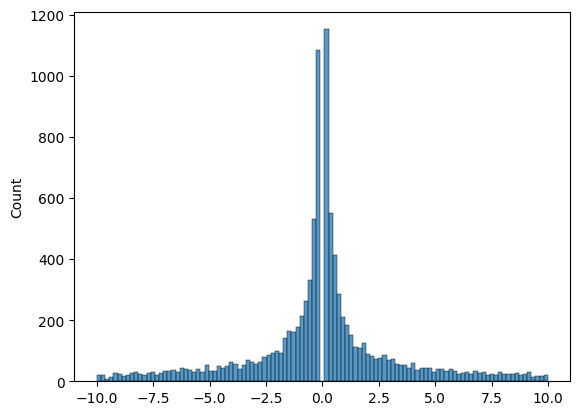

In [5]:
from SCRBenchmark.sampling import default_sampling
sns.histplot(default_sampling(10000, min_value=1.0e-1, max_value=1.0e1))

This sampling methodology more closely resembles data we would observe in real-world applications. 
Additionally, we can sample small training sets to analyze the capabilities of a shape-constrained regression algorithm to learn with little data (and under the presence of noise).

However, for validation of resulting trained function we sample a large dataset from a uniform distribution from the same input space. The larger set and uniform sampling increases the likelihood to detect local deviations from the defined constraints, and enables us to test the extrapolation capabilities of the models. This validation set does not contain noise and is fixed for **all benchmark instances of the same equation** to ensure comparability of results. 

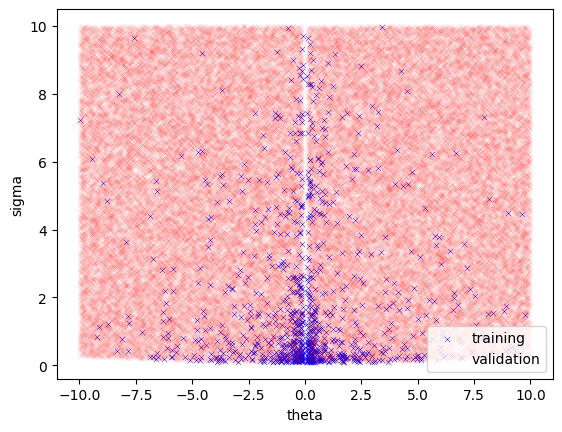

In [6]:
(training_df, test_df) = ICh6Eq20.create_dataframe(sample_size=1000, patience= 10, noise_level = 0, use_display_name = True)

fig = sns.scatterplot(x='theta', y='sigma', data=training_df, c = 'b', s = 15,  marker='x', label = 'training')
fig = sns.scatterplot(ax = fig, x='theta', y='sigma', data=test_df, c = 'r', s = 10,alpha=0.1,  marker='x', label="validation")

We can see that training data is dense at the joints. Whereas, the validation data is uniformly distributed in the whole sample space.

## The affect of added random noise
The `noise_level` parameter determines the severity of added artificial random normal noise. 
```python
import numpy as np
noise_level = 0.1
y = train[:,-1]
y_hat = y + np.random.normal(0,np.std(y)*np.sqrt(noise_level),len(y))
```

The affect of random noise is visualized in the following 2d example of equation `FeynmanICh6Eq20`.

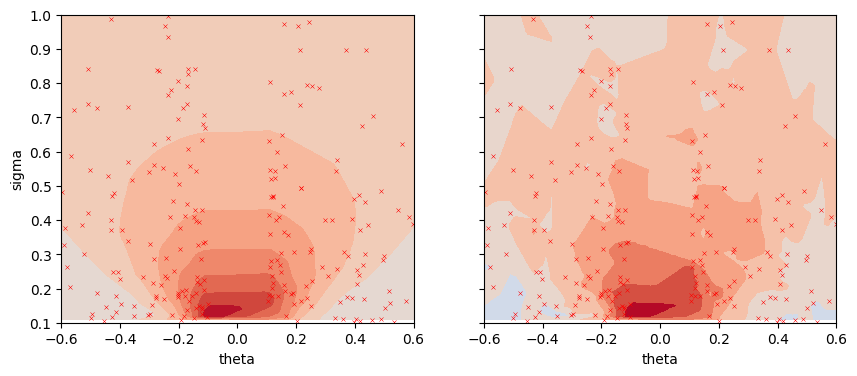

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import SCRBenchmark.SRSDFeynman as srsdf
from SCRBenchmark import Benchmark

from scipy.interpolate import griddata
import matplotlib.cm as cm
from matplotlib.colors import Normalize

#--------------------- plot a linear approximated contour plot -------------------------
# the benchmarks are sampled from a log10 based distribution of values skewed toward 
# their minimum value. The contourf plot however requries an equidistant grid of values.
# We generate this grid and use linear approximation to estimate a value for y at the 
# given grid coordinates. This allows us to plot a contour plot for sampled data.
fig, ax = plt.subplots(1,2, figsize=(10,4),  sharey=True)
def PlotContour(full, axis):
  zi = full['f']
  x = full['theta']
  y = full['sigma']
  # sigma in [0.1,10] and theta in [-10,0.1]u[0.1,10]
  # is the actual range generated by the FeynmanICh6Eq20 benchmark
  grid_x, grid_y = np.mgrid[-10:10:1000j, 0.1:10:1000j]
  grid_z0 = griddata((x,y), zi, (grid_x, grid_y), method='linear')

  norm = Normalize( vmin=-np.max(zi), vmax=np.max(zi))
  cmap = cm.get_cmap('coolwarm')
  axis.contourf(grid_x, grid_y, grid_z0, cmap= cmap , norm= norm)
  sns.scatterplot(ax = axis, x=full['theta'], y=full['sigma'], c = 'r', s = 8,  marker='x')
  sns.scatterplot(ax = axis, x=full['theta'], y=full['sigma'], c = 'r', s = 8,  marker='x')
  #only print a subset of the space sigma x theta \in [0.1,10]x[-10,10]
  #to increase the resolution of the interesting interaction
  axis.set_xlim([-0.6,0.6])
  axis.set_ylim([0.1,1])
  

ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20)
# ---------------------------------------------------------------------------------
# --------------------- plot benchmark instance WITHOUT noise ---------------------
# ---------------------------------------------------------------------------------
#set random seed to ensure that both example images show the same input distribution to better visualize the effect of added noise
np.random.seed(0) #CONSIDER REMOVAL IN PRODUCTION USE!

(training, test) = ICh6Eq20.create_dataframe(sample_size=1000, patience= 10, use_display_name = True)
PlotContour(training,ax[0])

# ------------------------------------------------------------------------------
# --------------------- plot benchmark instance WITH noise ---------------------
# ------------------------------------------------------------------------------
#set random seed to ensure that both example images show the same input distribution to better visualize the effect of added noise
np.random.seed(0) #CONSIDER REMOVAL IN PRODUCTION USE!

(training, test) = ICh6Eq20.create_dataframe(sample_size=1000, patience= 10,noise_level= 0.2,  use_display_name = True)
PlotContour(training,ax[1])


This example highlights the more _interesting_ area of 
$\theta \in [-0.6,0.6]$ and $\sigma \in [0.1,0.5]$
